In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [3]:
# Path setup
import pathlib

data_dir = pathlib.Path("images/")

image_count = len(list(data_dir.glob('*/*.png')))
print(f'Image Count: {image_count}')

Image Count: 612


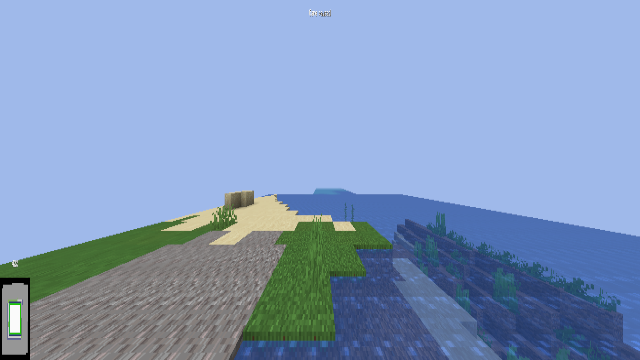

In [4]:
# Path testing
# bad_images = list(data_dir.glob('Bad/*'))
# PIL.Image.open(str(bad_images[0]))
good_images = list(data_dir.glob('Good/*'))
PIL.Image.open(str(good_images[5]))

In [5]:
# Train Dataset 
batch_size = 32
img_height = 360
img_width = 640 

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 612 files belonging to 3 classes.
Using 490 files for training.


In [6]:
# Validate Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 612 files belonging to 3 classes.
Using 122 files for validation.


In [7]:
# Class Name Test
class_names = train_ds.class_names
print(class_names)

['Bad', 'Good', 'Loading']


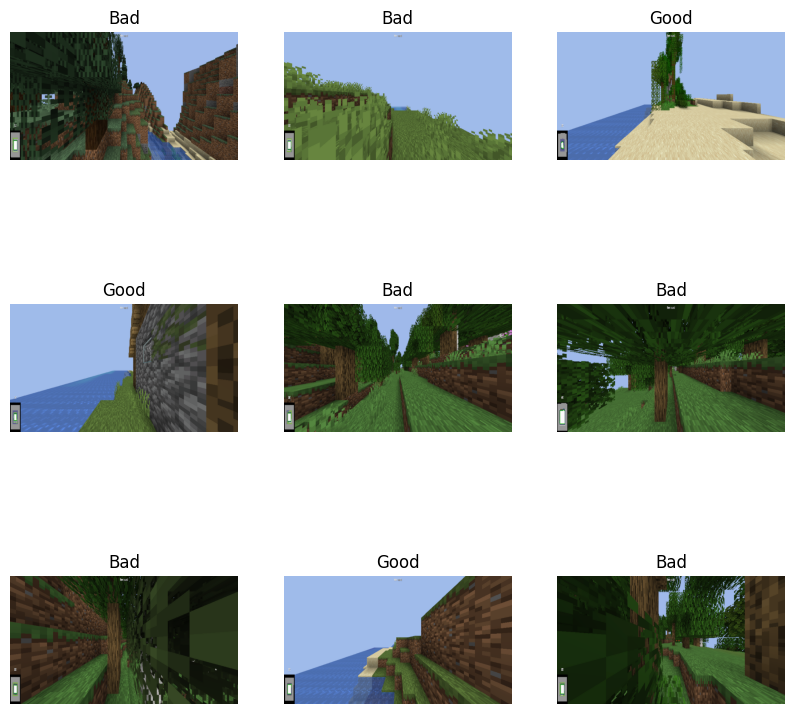

In [8]:
# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Batch Shapes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 640, 3)
(32,)


In [10]:
# Some random shit
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standardize the data
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9803922


In [12]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [13]:
# Model Creation
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs"),
])


In [14]:
# Model Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [15]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 360, 640, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 360, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 640, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 320, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 320, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 160, 32)      0         
 2D)                                                  

In [16]:
# Model Training
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
16/16 [==============================] - 35s 2s/step - loss: 0.9696 - accuracy: 0.5980 - val_loss: 0.6730 - val_accuracy: 0.6721
Epoch 2/30
16/16 [==============================] - 32s 2s/step - loss: 0.5356 - accuracy: 0.7224 - val_loss: 0.4353 - val_accuracy: 0.8197
Epoch 3/30
16/16 [==============================] - 33s 2s/step - loss: 0.4146 - accuracy: 0.8224 - val_loss: 0.3461 - val_accuracy: 0.8361
Epoch 4/30
16/16 [==============================] - 33s 2s/step - loss: 0.3780 - accuracy: 0.8327 - val_loss: 0.3433 - val_accuracy: 0.8689
Epoch 5/30
16/16 [==============================] - 32s 2s/step - loss: 0.3842 - accuracy: 0.8531 - val_loss: 0.2905 - val_accuracy: 0.8689
Epoch 6/30
16/16 [==============================] - 32s 2s/step - loss: 0.3045 - accuracy: 0.8898 - val_loss: 0.2459 - val_accuracy: 0.8934
Epoch 7/30
16/16 [==============================] - 33s 2s/step - loss: 0.2994 - accuracy: 0.8939 - val_loss: 0.2636 - val_accuracy: 0.8852
Epoch 8/30
16/16 [==

In [17]:
# Model Save
model_name = input("Enter model name: ")
model.save(save_format='h5', filepath=f"{model_name}.h5")
print(f'Saved as {model_name}.h5')

Saved as model3.h5


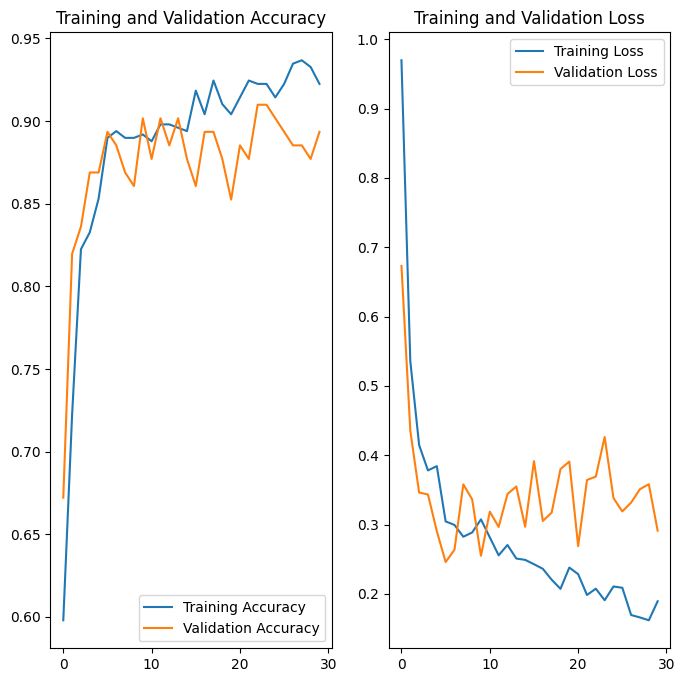

In [18]:
# Visualize
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# File Dialogue
from PyQt5.QtWidgets import QFileDialog
%gui qt


def gui_fname(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None:
        dir = './'
    fname = QFileDialog.getOpenFileName(None, "Select data file...",
                                        dir, filter="All files (*);; SM Files (*.sm)")
    return fname[0]


In [20]:
# Prediction Function
def predict_img(file):
    model = keras.models.load_model('model2.h5')
    img = tf.keras.utils.load_img(
        file, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return class_names[np.argmax(score)]

In [21]:
prediction = predict_img(gui_fname())

print(
    f"This image most likely belongs to {prediction}"
)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
# Sunflower Testing
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
